In [1]:
%reset -f
import sympy as sym

sym.var('q0 q1 L0 L1 l0 l1')

T_0_org = sym.Matrix([[sym.cos(q0), 0, -sym.sin(q0), L0*sym.cos(q0)], 
                      [0, 1, 0, 0],
                      [sym.sin(q0), 0, sym.cos(q0), L0*sym.sin(q0)],
                      [0, 0, 0, 1]])
T_1_0 = sym.Matrix([[sym.cos(q1), 0, -sym.sin(q1), L1*sym.cos(q1)], 
                    [0, 1, 0, 0],
                    [sym.sin(q1), 0, sym.cos(q1), L1*sym.sin(q1)],
                    [0, 0, 0, 1]])

com0 = sym.Matrix([[l0*sym.cos(q0)],
                   [0],
                   [l0*sym.sin(q0)],
                   [1]])
com1 = sym.Matrix([[l1*sym.cos(q1)],
                   [0],
                   [l1*sym.sin(q1)],
                   [1]])

xee = sym.Matrix([[L1*sym.cos(q1)], 
                  [0],
                  [L1*sym.sin(q1)],
                  [1]])

# jacobian of the end effector (linear part)
JEE_v = (T_0_org.multiply(xee)).jacobian([q0, q1])
JEE = JEE_v.row_del(3)

'''
xee = sym.Matrix([[0],  #L1*sym.cos(q1)],  
                  [0],
                  [0],  #L1*sym.sin(q1)],
                  [1]])

T_1_org = T_0_org.multiply(T_1_0)
JEE_v = (T_1_org.multiply(xee)).jacobian([q0, q1])
JEE_v.row_del(3)
JEE_v
'''


'\nxee = sym.Matrix([[0],  #L1*sym.cos(q1)],  \n                  [0],\n                  [0],  #L1*sym.sin(q1)],\n                  [1]])\n\nT_1_org = T_0_org.multiply(T_1_0)\nJEE_v = (T_1_org.multiply(xee)).jacobian([q0, q1])\nJEE_v.row_del(3)\nJEE_v\n'

In [2]:
# jacobian of the end effector (angular part)
# y-axis rotation only
JEE_w = sym.Matrix([[0, 0], 
                    [1, 1],
                    [0, 0]])

# full jacobian
JEE = JEE_v.row_insert(4, JEE_w)
JEE

Matrix([
[-L0*sin(q0) - L1*sin(q0)*cos(q1) - L1*sin(q1)*cos(q0), -L1*sin(q0)*cos(q1) - L1*sin(q1)*cos(q0)],
[                                                    0,                                        0],
[ L0*cos(q0) - L1*sin(q0)*sin(q1) + L1*cos(q0)*cos(q1), -L1*sin(q0)*sin(q1) + L1*cos(q0)*cos(q1)],
[                                                    0,                                        0],
[                                                    1,                                        1],
[                                                    0,                                        0]])

In [3]:
import numpy as np

length0 = 0.3  # leg link 0 length, m
length1 = 0.301  # leg link 1 length, m
l = length0*np.sin(45*np.pi/180)+length1*np.sin(45*np.pi/180)  # nominal body height
k_j = 1.8  # ratio of jump height to body height
d = k_j*l  # jump displacement as a fn of body height, m
m = 10  # mass, kg

g = -9.807  # earth gravity

q0_low = -150*np.pi/180  # just guesses. Joint angles at lowest crouch in joint frame
q1_low = 120*np.pi/180
q0_hi = -90*np.pi/180  # just guesses. Joint angles at toe-off in joint frame
q1_hi = 0*np.pi/180
l_low = length0*np.sin(-q0_low)+length1*np.sin(-q1_low - q0_low)  # crouch height
l_hi = length0*np.sin(-q0_hi)+length1*np.sin(-q1_hi - q0_hi)  # toe-off height
s = l_hi - l_low  # assume lift-off stroke to be specified percent of leg length
if s < 0:
    print("ERROR: crouch height greater than toe-off height")
    
v0 = np.sqrt(-2*g*d)  # lift-off speed required to jump d meters
a = (v0**2)/(2*s)
t = v0/a
F = m*(a - g)  # required vertical force, N

r = int(np.abs(q0_low - q0_hi)*180/np.pi)  # range of motion in degrees for link 0 (link 1 moves 2x as much)
omega0 = r/(t*360/60)
omega1 = 2*r/(t*360/60)

print("Assuming crouch height is", l_low, "m and toe-off height is", l_hi, "m:")
print("For a jump height of ", d+l, "m from the ground:")
print("Vertical force required is", F, "N")
print("Lift-off time based on stroke of", s, "m is", t, "s")
print("Required angular vel for actuator 0 is", omega0, "rpm")
print("Required angular vel for actuator 1 is", omega1, "rpm")

Assuming crouch height is 0.3005 m and toe-off height is 0.601 m:
For a jump height of  1.189919291380722 m from the ground:
Vertical force required is 347.715463311473 N
Lift-off time based on stroke of 0.3005 m is 0.15515843729698112 s
Required angular vel for actuator 0 is 64.45024952693673 rpm
Required angular vel for actuator 1 is 128.90049905387346 rpm


In [4]:
F_l = sym.Matrix([[100],[0],[F],[0],[0],[0]])  # task space force vector
F_q = (JEE.T).multiply(F_l)  # conversion to joint space

torque = F_q.subs({q0:q0_low, q1:q1_low, L0:length0, L1:length1})  # torques required for each actuator at given angle
F_q

Matrix([
[-100*L0*sin(q0) + 347.715463311473*L0*cos(q0) - 347.715463311473*L1*sin(q0)*sin(q1) - 100*L1*sin(q0)*cos(q1) - 100*L1*sin(q1)*cos(q0) + 347.715463311473*L1*cos(q0)*cos(q1)],
[                                               -347.715463311473*L1*sin(q0)*sin(q1) - 100*L1*sin(q0)*cos(q1) - 100*L1*sin(q1)*cos(q0) + 347.715463311473*L1*cos(q0)*cos(q1)]])

Text(0.5, 1.0, 'q1 torque')

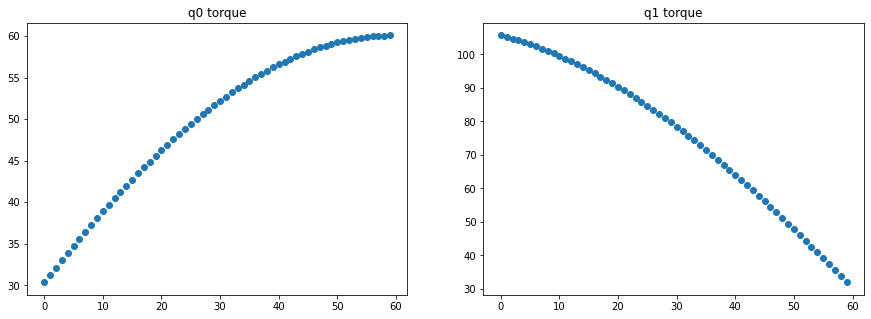

In [5]:
# Check required torques over full RoM
import matplotlib.pyplot as plt
from sympy.utilities.iterables import flatten

fig, ax = plt.subplots(1, 2, figsize=(15,5))

tau = np.zeros((2, r))
i = 0
for theta in range(0, r):
    q0_i = q0_low + (theta*np.pi/180)
    q1_i = q1_low - (theta*2*np.pi/180)
    tau[:, i] = flatten(F_q.subs({q0:q0_i, q1:q1_i, L0:length0, L1:length1}))
    i += 1

ax[0].scatter(range(0, r), tau[0,:])
ax[0].set_title('q0 torque')
ax[1].scatter(range(0, r), tau[1,:])
ax[1].set_title('q1 torque')

In [6]:
print("Max torque of q0 is", np.max(abs(tau[0,:])), "Nm")
print("Max torque of q1 is", np.max(abs(tau[1,:])), "Nm")

Max torque of q0 is 60.09691495048932 Nm
Max torque of q1 is 105.69025777943989 Nm
